# Chapter 6 - Decision Trees

## Setup

Let's import a few common modules, ensure MatplotLib plots figures inline and prepare function to save the figures:

In [1]:
# Common Imports
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = 'decision_trees'

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving Figure ", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

## Training and Visualizing a Decision Tree

The following code trains a `DecisionTreeClassifier` on the iris dataset:

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

We can visualize the trained Decision Tree by using `export_graphviz()` method to output a graph definition file called `iris_tree.dot`:

In [3]:
from sklearn.tree import export_graphviz

export_graphviz(tree_clf,
                out_file=image_path("iris_tree.dot"),
                feature_names=iris.feature_names[2:],
                class_names=iris.target_names,
                rounded=True,
                filled=True
            )

![Decision Tree](images/decision_trees/iris_tree.png)

In a Decision Tree a node has an attribute name `gini`. It measures the ***purity*** of a node: a node is "pure" (`gini=0`) if all training instances it applies to belong to the same class. Equation below show how the training algorithm computes the gini score $G_i$ of the $i^{th}$ node.

**Equation 6-1. *Gini impurity***

$$ G_i = 1 - \sum \limits _{k=1} ^{n} p_{i, k}^2 $$
 * $p_{i, k}$ is the ratio of class $k$ instances among the training instances in the $i^{th}$ node. 

Let's plot the decision boundaries of this model.

Saving Figure  decision_tree_decision_boundaries_plot


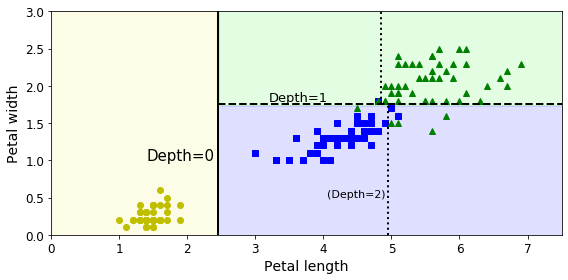

In [4]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Verginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

## Estimating Class Probabilities

Let's check the class probabilities for a flower whose petals are 5cm long and 1.5cm wide.

In [5]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [6]:
tree_clf.predict([[5, 1.5]])

array([1])

## The CART Training Algorithm

Scikit-Learn uses the ***Classification And Regression Tree (CART)*** algorithm to train Decision Trees. The algorithm first splits the training set in two subsets using a single feature $k$ and a threshold $t_k$ (e.g., `petal_length ≤ 2.45 cm`). It chooses $k$ and $t_k$ by searching for the pair $(k, t_k)$ that produces the purest subsets (weighted by their size). The cost function that the algorithm tries to minimize is given by the equation below.

**Equation 6-2. *CART cost function for classification***

$$ J(k, t_k) = \frac{m_{left}}{m} G_{left} + \frac{m{right}}{m} G_{right} $$

where $ \begin{cases} G_{left/right} & measures & the & impurity & of & the & left/right & subset, \\ m_{left/right} & is & the & number & of & instances & in & the & left/right & subset. \end{cases} $

Once it has successfully split the training set in two, it splits the subsets using the same logic, then the sub-subsets and so on, recursively. It stops recursing once it reaches the maximum depth (defined by the `max_depth` hyperparameter), or if it cannot find a split that will reduce impurity. 

## Computational Complexity

Making predictions requires traversing the Decision Tree from the root to a leaf. Decision Trees are generally approximately balanced, so traversing the Decision Tree requires going through roughly $O(log_2(m))$ nodes. Since each node only requires checking the value of one feature, the overall prediction complexity is just $O(log_2(m))$, independent of the number of features. So predictions are very fast, even when dealing with large training sets.

However, the training algorithm compares all features (or less if `max_features` is set) on all samples at each node. This results in a training complexity of $O(n \times mlog(m))$. For small training sets (less than a few thousand instances), Scikit-Learn can speed up training by presorting the data (set `presort=True`), but this slows down training considerably for larger training sets.

## Entropy Impurity Measure 

By default, the Gini impurity measure is used, but we can select the entropy impurity measure instead by setting the `criterion` hyperparameter to `"entropy"`. It is frequently used as an impurity measure: a set’s entropy is zero when it contains instances of only one class. Equation below shows the definition of the entropy of the $i_{th}$ node.

**Equation 6-3. Entropy**

$$ H_i = - \sum \limits _{k=1,{p_{i, k} ^{\neq 0}}} ^{n} p_{i, k} log \left( p_{i, k} \right) $$

Gini impurity is slightly faster to compute, so it is a good default. However, when they differ, Gini impurity tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce slightly more balanced trees. But most of the time it does not make a big difference: they lead to similar trees. 

## Regularization Hyperparameters

The `DecisionTreeClassifier` class has a few parameters that restrict the shape of the Decision Tree:
 * `max_depth` - controls the maximum depth of the Decision Tree. 
 * `min_samples_split` - The minimum number of samples a node must have before it can be split.
 * `min_samples_leaf` - The minimum number of samples a leaf node must have.
 * `min_weight_fraction_leaf` - Same as `min_samples_leaf` but expressed as a fraction of the total number of weighted instances.
 * `max_leaf_nodes` - Maximum number of leaf nodes.
 * `max_features` -Maximum number of features that are evaluated for splitting at each node
 
Increasing *min_hyperparameters* or reducing *max_hyperparameters* will regularize the model.

Figure below shows two Decision Trees trained on the moons dataset. 
 * On the left, the Decision Tree is trained with the default hyperparameters (i.e., no restrictions), and 
 * On the right the Decision Tree is trained with `min_samples_leaf=4`.

Saving Figure  min_samples_leaf_plot


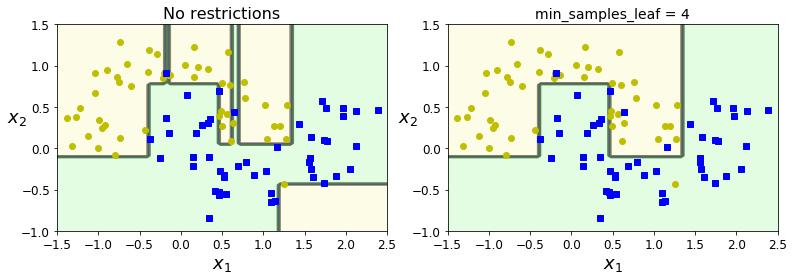

In [7]:
from sklearn.datasets import make_moons

Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)

deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

save_fig("min_samples_leaf_plot")
plt.show()

It is quite obvious that the model on the left is overfitting, and the model on the right will probably generalize better.

## Regression Trees

Decision Trees are also capable of performing regression tasks. Let’s build a regression tree using Scikit-Learn’s `DecisionTreeRegressor` class, training it on a noisy quadratic dataset with `max_depth=2`:

In [8]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1)/ 10

In [9]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

The resulting tree is represented on the figure below:

In [10]:
export_graphviz(
    tree_reg,
    out_file=image_path("regression_tree.dot"),
    feature_names=["x1"],
    rounded=True,
    filled=True
)

![Decision Tree](images\decision_trees\regression_tree.png)

This model’s predictions are represented on the left of the figure below. If we set `max_depth=3`, we get the predictions represented on the right. The predicted value for each region is always the average target value of the instances in that region. The algorithm splits each region in a way that makes most training instances as close as possible to that predicted value.

Saving Figure  tree_regression_plot


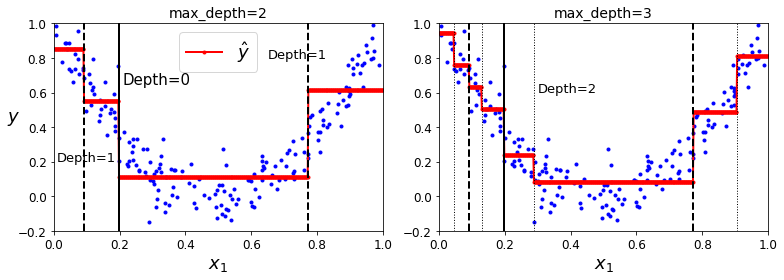

In [11]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.6, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

The CART algorithm works mostly the same way as earlier, except that instead of trying to split the training set in a way that minimizes impurity, it now tries to split the training set in a way that minimizes the MSE. Following equation shows the cost function that the algorithm tries to minimize.

**Equation 6-5. *CART cost function for regression***

$$ J \left( k, t_k \right) = \frac{m_{left}}{m} MSE_{left} + \frac{m_{right}}{m} MSE_{right} $$

where $ \begin{cases} MSE_{node} = \sum \limits _{i \in node} \left( \hat{y}_{node} - y^{(i)} \right)^2 \\ \hat{y}_{node} = \frac{1}{m_{node}} \sum \limits _{i \in node} y^{(i)} \end{cases} $

Just like for classification tasks, Decision Trees are prone to overfitting when dealing with regression tasks. Without any regularization (i.e., using the default hyperparameters), you get the predictions on the left of the figure below. It is obviously overfitting the training set very badly. Just setting `min_samples_leaf=10` results in a much more reasonable model, represented on the right of the figure.

Saving Figure  tree_regression_regularization_plot


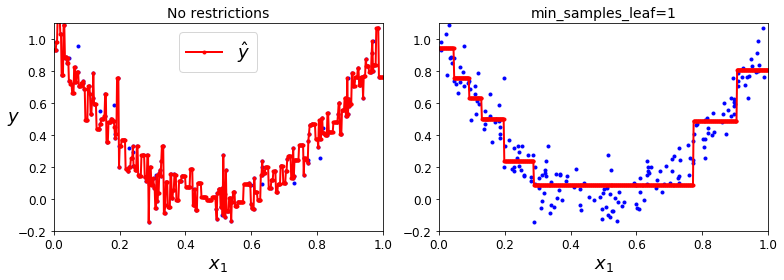

In [12]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
teee_reg2 = DecisionTreeRegressor(min_samples_leaf=10, random_state=42)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

## Instability

Decision Trees love orthogonal decision boundaries (all splits are perpendicular to an axis), which makes them sensitive to training set rotation. For example, figure below shows a simple linearly separable dataset: on the left, a Decision Tree can split it easily, while on the right, after the dataset is rotated by $45°$, the decision boundary looks unnecessarily convoluted. Although both Decision Trees fit the training set perfectly, it is very likely that the model on the right will not generalize well. One way to limit this problem is to use **PCA**, which often results in a better orientation of the training data.

Saving Figure  sensitivity_to_rotation_plot


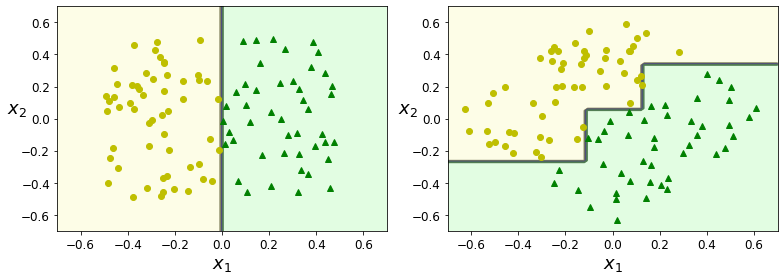

In [16]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

save_fig("sensitivity_to_rotation_plot")
plt.show()

Another example of rotated dataset:

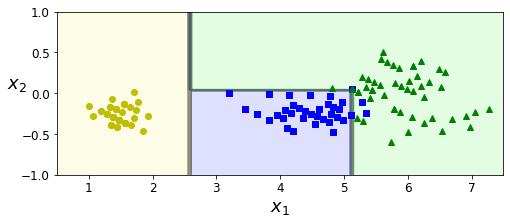

In [27]:
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()

The main issue with Decision Trees is that they are very sensitive to small variations in the training data. For example, if we just remove the widest Iris-Versicolor from the iris training set (the one with petals $4.8$ cm long and $1.8$ cm wide) and train a new Decision Tree, we may get the model represented in the figure below.

In [23]:
iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # Widest Iris-Versicolor flower

array([[4.8, 1.8]])

In [24]:
not_widest_versicolor = (X[:, 1] != 1.8) | (y == 2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=40, splitter='best')

Saving Figure  decision_tree_instability_plot


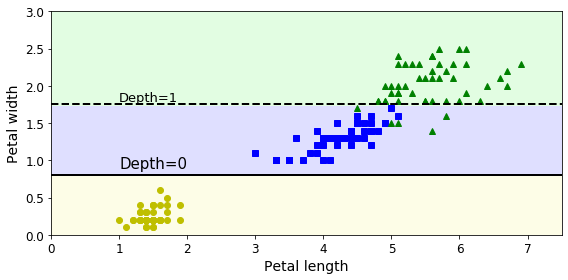

In [26]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

save_fig("decision_tree_instability_plot")
plt.show()

As we can see, it looks very different from the previous Decision Tree. Actually, since the training algorithm used by Scikit-Learn is stochastic we may get very different models even on the same training data (unless we set the `random_state` hyperparameter).

## Exercise Solutions

### 7.

Exercise: *Train and fine-tune a Decision Tree for the moons dataset.*
 * Generate a moons dataset using `make_moons(n_samples=10000, noise=0.4)`.
 * Split it into a training set and a test set using `train_test_split()`.
 * Use grid search with cross-validation (with the help of the `GridSearchCV` class) to find good hyperparameter values for a `DecisionTreeClassifier`. Hint: try various values for `max_leaf_nodes`.
 * Train it on the full training set using these hyperparameters, and measure your model’s performance on the test set. You should get roughly $85\%$ to $87\%$ accuracy.

**Part 1**

In [28]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

**Part 2**

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Part 3**

In [34]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 882 out of 882 | elapsed:   30.5s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
  

In [35]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=17,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

**Part 4**

In [37]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

### 8

Grow a forest.
  * Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: you can use Scikit-Learn’s `ShuffleSplit` class for this.
  * Train one Decision Tree on each subset, using the best hyperparameter values found above. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about $80\%$ accuracy.
  * Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy’s `mode()` function forthis). This gives you majority-vote predictions over the test set.
  * Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than yourfirst model (about $0.5$ to $1.5\%$ higher). Congratulations, you have trained a **Random Forest classifier**!

**Part 1**

In [39]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

**Part 2**

In [40]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8054499999999999

**Part 3**

In [47]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [52]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

**Part 4**

In [53]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872